In [44]:
import pandas as pd
import krippendorff
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats import inter_rater as irr
from scipy.io.arff import loadarff
import numpy as np

from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

def agreement_calculation(df, name_columns):
    results = []

    for i in name_columns:
        results.append(list(df[i]))
    
    unique = list(set([x for xs in results for x in xs]))
    le = LabelEncoder()
    le.fit(unique)

    if(len(results) <= 2):

        encod_rater1 = le.transform(results[0])
        encod_rater2 = le.transform(results[1])
        kappa_cohen = cohen_kappa_score(encod_rater1, encod_rater2)

        print("Kappa Cohen: ", kappa_cohen, "\n")

    else:

        print("Kappa Cohen:  There are more than two annotators! In this case, use Kappa Fleiss or Krippendorff's Alpha.\n")

    encod_rater = []

    for i in range(len(results)):
        encod_rater.append(le.transform(results[i]))

    giro = np.array(encod_rater).transpose()
    kappa_fleiss = irr.fleiss_kappa(irr.aggregate_raters(giro)[0], method='fleiss')

    print("Kappa Fleiss: ", kappa_fleiss, "\n")

    alpha = krippendorff.alpha(reliability_data=results, level_of_measurement="nominal")

    print("Krippendorff's alpha for nominal metric: ", alpha, "\n")
    
    return kappa_cohen

def trainer_fixed_pipeline(df_xtrain, df_xtest):
    df_ytrain = df_xtrain['class'].copy()
    df_xtrain = df_xtrain.drop(columns=['class'])
    df_ytest = df_xtest['class'].copy()
    df_xtest = df_xtest.drop(columns=['class'])
    
    rf = RandomForestClassifier(n_estimators=10).fit(df_xtrain, df_ytrain)
    y_pred_rf = rf.predict(df_xtest)
    print("Classification report RF: \n", classification_report(df_ytest, y_pred_rf))
    
    knn = KNeighborsClassifier().fit(df_xtrain, df_ytrain)
    y_pred_knn = knn.predict(df_xtest)
    print("Classification report KNN: \n", classification_report(df_ytest, y_pred_knn))
    
    nb = MultinomialNB().fit(df_xtrain, df_ytrain)
    y_pred_nb = nb.predict(df_xtest)
    print("Classification report NB: \n", classification_report(df_ytest, y_pred_nb))
    
    lr = LogisticRegression().fit(df_xtrain, df_ytrain)
    y_pred_lr = lr.predict(df_xtest)
    print("Classification report LR: \n", classification_report(df_ytest, y_pred_lr))
    
    vector = None
    
    return vector, rf, y_pred_rf, knn, y_pred_knn, nb, y_pred_nb, lr, y_pred_lr

In [45]:
raw_data = loadarff('datasets/eletricity/electricity-normalized.arff')
df = pd.DataFrame(raw_data[0])

X = df.drop('class', axis=1)
y = df['class']
y = y.astype(str)

y = y.replace("b'UP'", 'UP')
y = y.replace("b'DOWN'", 'DOWN')

X_train, X_test, y_train, y_test = train_test_split(
 X, y, test_size=0.33, random_state=42)

df_xtrain = pd.concat([X_train, y_train], axis=1)
df_xtest = pd.concat([X_test, y_test], axis=1)

df_agreement = X_train.copy()
df_agreement['target'] = y_train
df_agreement['rater'] = y_train
df_agreement = df_agreement[['target', 'rater']]
df_agreement_temp = df_agreement.copy()

name_columns = [
    'target',
    'rater'
]
    
display(df_agreement)

,target,rater
24280,UP,UP
41480,DOWN,DOWN
43103,DOWN,DOWN
1060,DOWN,DOWN
5124,UP,UP
...,...,...
11284,DOWN,DOWN
44732,DOWN,DOWN
38158,UP,UP
860,UP,UP


# Agreement 1.0

In [46]:
kappa_100 = agreement_calculation(df_agreement, name_columns)

if kappa_100 == 1:
    vector100, rf100, y_pred_rf100, knn100, y_pred_knn100, nb100, y_pred_nb100, lr100, y_pred_lr100 = trainer_fixed_pipeline(df_xtrain, df_xtest)

Kappa Cohen:  1.0 

Kappa Fleiss:  1.0 

Krippendorff's alpha for nominal metric:  1.0 

Classification report RF: 
               precision    recall  f1-score   support

        DOWN       0.88      0.92      0.90      8619
          UP       0.88      0.83      0.86      6334

    accuracy                           0.88     14953
   macro avg       0.88      0.88      0.88     14953
weighted avg       0.88      0.88      0.88     14953

Classification report KNN: 
               precision    recall  f1-score   support

        DOWN       0.81      0.84      0.83      8619
          UP       0.77      0.74      0.75      6334

    accuracy                           0.80     14953
   macro avg       0.79      0.79      0.79     14953
weighted avg       0.80      0.80      0.80     14953

Classification report NB: 
               precision    recall  f1-score   support

        DOWN       0.58      1.00      0.73      8619
          UP       0.94      0.02      0.03      6334

    accu

# Agreement 0.90

In [47]:
df_agreement = df_agreement_temp.copy()

for i in range(1200):
    if(df_agreement['rater'].iloc[i] == 'UP'):
        df_agreement['rater'].iloc[i] = 'DOWN'
    else:
        df_agreement['rater'].iloc[i] = 'UP'

kappa_90 = agreement_calculation(df_agreement, name_columns)
df_xtrain['class'] = df_agreement['rater']

if (kappa_90 >= 0.88) and (kappa_90 <= 0.92):
    vector90, rf90, y_pred_rf90, knn90, y_pred_knn90, nb90, y_pred_nb90, lr90, y_pred_lr90 = trainer_fixed_pipeline(df_xtrain, df_xtest)

Kappa Cohen:  0.9192315428063866 

Kappa Fleiss:  0.9192300758652157 

Krippendorff's alpha for nominal metric:  0.9192314061119979 

Classification report RF: 
               precision    recall  f1-score   support

        DOWN       0.87      0.92      0.90      8619
          UP       0.89      0.82      0.85      6334

    accuracy                           0.88     14953
   macro avg       0.88      0.87      0.87     14953
weighted avg       0.88      0.88      0.88     14953

Classification report KNN: 
               precision    recall  f1-score   support

        DOWN       0.80      0.83      0.82      8619
          UP       0.76      0.72      0.74      6334

    accuracy                           0.79     14953
   macro avg       0.78      0.78      0.78     14953
weighted avg       0.79      0.79      0.79     14953

Classification report NB: 
               precision    recall  f1-score   support

        DOWN       0.58      1.00      0.73      8619
          UP      

# Agreement 0.80

In [48]:
df_agreement = df_agreement_temp.copy()

for i in range(2800):
    if(df_agreement['rater'].iloc[i] == 'UP'):
        df_agreement['rater'].iloc[i] = 'DOWN'
    else:
        df_agreement['rater'].iloc[i] = 'UP'

kappa_80 = agreement_calculation(df_agreement, name_columns)
df_xtrain['class'] = df_agreement['rater']

if (kappa_80 >= 0.78) and (kappa_80 <= 0.82):
    vector80, rf80, y_pred_rf80, knn80, y_pred_knn80, nb80, y_pred_nb80, lr80, y_pred_lr80 = trainer_fixed_pipeline(df_xtrain, df_xtest)

Kappa Cohen:  0.8120827710696389 

Kappa Fleiss:  0.8120471636357478 

Krippendorff's alpha for nominal metric:  0.8120502591401512 

Classification report RF: 
               precision    recall  f1-score   support

        DOWN       0.85      0.91      0.88      8619
          UP       0.87      0.78      0.82      6334

    accuracy                           0.86     14953
   macro avg       0.86      0.85      0.85     14953
weighted avg       0.86      0.86      0.85     14953

Classification report KNN: 
               precision    recall  f1-score   support

        DOWN       0.79      0.82      0.80      8619
          UP       0.74      0.71      0.72      6334

    accuracy                           0.77     14953
   macro avg       0.77      0.76      0.76     14953
weighted avg       0.77      0.77      0.77     14953

Classification report NB: 
               precision    recall  f1-score   support

        DOWN       0.58      1.00      0.73      8619
          UP      

# Agreement 0.70

In [49]:
df_agreement = df_agreement_temp.copy()

for i in range(4300):
    if(df_agreement['rater'].iloc[i] == 'UP'):
        df_agreement['rater'].iloc[i] = 'DOWN'
    else:
        df_agreement['rater'].iloc[i] = 'UP'

kappa_70 = agreement_calculation(df_agreement, name_columns)
df_xtrain['class'] = df_agreement['rater']

if (kappa_70 >= 0.68) and (kappa_70 <= 0.72):
    vector70, rf70, y_pred_rf70, knn70, y_pred_knn70, nb70, y_pred_nb70, lr70, y_pred_lr70 = trainer_fixed_pipeline(df_xtrain, df_xtest)

Kappa Cohen:  0.7121140474871421 

Kappa Fleiss:  0.7119773788582154 

Krippendorff's alpha for nominal metric:  0.7119821224700134 

Classification report RF: 
               precision    recall  f1-score   support

        DOWN       0.83      0.89      0.86      8619
          UP       0.84      0.76      0.80      6334

    accuracy                           0.84     14953
   macro avg       0.84      0.83      0.83     14953
weighted avg       0.84      0.84      0.83     14953

Classification report KNN: 
               precision    recall  f1-score   support

        DOWN       0.78      0.80      0.79      8619
          UP       0.72      0.69      0.71      6334

    accuracy                           0.75     14953
   macro avg       0.75      0.75      0.75     14953
weighted avg       0.75      0.75      0.75     14953

Classification report NB: 
               precision    recall  f1-score   support

        DOWN       0.58      1.00      0.73      8619
          UP      

# Agreement 0.60

In [50]:
df_agreement = df_agreement_temp.copy()

for i in range(5700):
    if(df_agreement['rater'].iloc[i] == 'UP'):
        df_agreement['rater'].iloc[i] = 'DOWN'
    else:
        df_agreement['rater'].iloc[i] = 'UP'

kappa_60 = agreement_calculation(df_agreement, name_columns)
df_xtrain['class'] = df_agreement['rater']

if (kappa_60 >= 0.58) and (kappa_60 <= 0.62):
    vector60, rf60, y_pred_rf60, knn60, y_pred_knn60, nb60, y_pred_nb60, lr60, y_pred_lr60 = trainer_fixed_pipeline(df_xtrain, df_xtest)

Kappa Cohen:  0.6191027357421042 

Kappa Fleiss:  0.6188038887460704 

Krippendorff's alpha for nominal metric:  0.6188101668861813 

Classification report RF: 
               precision    recall  f1-score   support

        DOWN       0.81      0.87      0.84      8619
          UP       0.81      0.72      0.76      6334

    accuracy                           0.81     14953
   macro avg       0.81      0.80      0.80     14953
weighted avg       0.81      0.81      0.81     14953

Classification report KNN: 
               precision    recall  f1-score   support

        DOWN       0.77      0.78      0.77      8619
          UP       0.69      0.68      0.68      6334

    accuracy                           0.73     14953
   macro avg       0.73      0.73      0.73     14953
weighted avg       0.73      0.73      0.73     14953

Classification report NB: 
               precision    recall  f1-score   support

        DOWN       0.58      1.00      0.73      8619
          UP      

# Agreement 0.50

In [51]:
df_agreement = df_agreement_temp.copy()

for i in range(7300):
    if(df_agreement['rater'].iloc[i] == 'UP'):
        df_agreement['rater'].iloc[i] = 'DOWN'
    else:
        df_agreement['rater'].iloc[i] = 'UP'

kappa_50 = agreement_calculation(df_agreement, name_columns)
df_xtrain['class'] = df_agreement['rater']

if (kappa_50 >= 0.48) and (kappa_50 <= 0.52):
    vector50, rf50, y_pred_rf50, knn50, y_pred_knn50, nb50, y_pred_nb50, lr50, y_pred_lr50 = trainer_fixed_pipeline(df_xtrain, df_xtest)

Kappa Cohen:  0.5134325262755486 

Kappa Fleiss:  0.5127853710745655 

Krippendorff's alpha for nominal metric:  0.5127933952952073 

Classification report RF: 
               precision    recall  f1-score   support

        DOWN       0.78      0.84      0.81      8619
          UP       0.76      0.67      0.71      6334

    accuracy                           0.77     14953
   macro avg       0.77      0.76      0.76     14953
weighted avg       0.77      0.77      0.77     14953

Classification report KNN: 
               precision    recall  f1-score   support

        DOWN       0.75      0.74      0.75      8619
          UP       0.65      0.66      0.66      6334

    accuracy                           0.71     14953
   macro avg       0.70      0.70      0.70     14953
weighted avg       0.71      0.71      0.71     14953

Classification report NB: 
               precision    recall  f1-score   support

        DOWN       0.58      1.00      0.73      8619
          UP      

# Agreement 0.40

In [52]:
df_agreement = df_agreement_temp.copy()

for i in range(9000):
    if(df_agreement['rater'].iloc[i] == 'UP'):
        df_agreement['rater'].iloc[i] = 'DOWN'
    else:
        df_agreement['rater'].iloc[i] = 'UP'

kappa_40 = agreement_calculation(df_agreement, name_columns)
df_xtrain['class'] = df_agreement['rater']

if (kappa_40 >= 0.38) and (kappa_40 <= 0.42):
    vector40, rf40, y_pred_rf40, knn40, y_pred_knn40, nb40, y_pred_nb40, lr40, y_pred_lr40 = trainer_fixed_pipeline(df_xtrain, df_xtest)

Kappa Cohen:  0.40148637094627504 

Kappa Fleiss:  0.4003280632218138 

Krippendorff's alpha for nominal metric:  0.4003379395671608 

Classification report RF: 
               precision    recall  f1-score   support

        DOWN       0.74      0.80      0.77      8619
          UP       0.69      0.62      0.65      6334

    accuracy                           0.72     14953
   macro avg       0.72      0.71      0.71     14953
weighted avg       0.72      0.72      0.72     14953

Classification report KNN: 
               precision    recall  f1-score   support

        DOWN       0.72      0.71      0.71      8619
          UP       0.61      0.63      0.62      6334

    accuracy                           0.67     14953
   macro avg       0.67      0.67      0.67     14953
weighted avg       0.67      0.67      0.67     14953

Classification report NB: 
               precision    recall  f1-score   support

        DOWN       0.58      1.00      0.73      8619
          UP     

# Agreement 0.30

In [53]:
df_agreement = df_agreement_temp.copy()

for i in range(10500):
    if(df_agreement['rater'].iloc[i] == 'UP'):
        df_agreement['rater'].iloc[i] = 'DOWN'
    else:
        df_agreement['rater'].iloc[i] = 'UP'

kappa_30 = agreement_calculation(df_agreement, name_columns)
df_xtrain['class'] = df_agreement['rater']

if (kappa_30 >= 0.28) and (kappa_30 <= 0.32):
    vector30, rf30, y_pred_rf30, knn30, y_pred_knn30, nb30, y_pred_nb30, lr30, y_pred_lr30 = trainer_fixed_pipeline(df_xtrain, df_xtest)

Kappa Cohen:  0.30305476841090395 

Kappa Fleiss:  0.3012947002989474 

Krippendorff's alpha for nominal metric:  0.30130620768225547 

Classification report RF: 
               precision    recall  f1-score   support

        DOWN       0.70      0.75      0.73      8619
          UP       0.62      0.57      0.59      6334

    accuracy                           0.67     14953
   macro avg       0.66      0.66      0.66     14953
weighted avg       0.67      0.67      0.67     14953

Classification report KNN: 
               precision    recall  f1-score   support

        DOWN       0.69      0.66      0.68      8619
          UP       0.56      0.60      0.58      6334

    accuracy                           0.63     14953
   macro avg       0.63      0.63      0.63     14953
weighted avg       0.64      0.63      0.64     14953

Classification report NB: 
               precision    recall  f1-score   support

        DOWN       0.58      1.00      0.73      8619
          UP    

# Agreement 0.20

In [54]:
df_agreement = df_agreement_temp.copy()

for i in range(12000):
    if(df_agreement['rater'].iloc[i] == 'UP'):
        df_agreement['rater'].iloc[i] = 'DOWN'
    else:
        df_agreement['rater'].iloc[i] = 'UP'

kappa_20 = agreement_calculation(df_agreement, name_columns)
df_xtrain['class'] = df_agreement['rater']

if (kappa_20 >= 0.18) and (kappa_20 <= 0.22):
    vector20, rf20, y_pred_rf20, knn20, y_pred_knn20, nb20, y_pred_nb20, lr20, y_pred_lr20 = trainer_fixed_pipeline(df_xtrain, df_xtest)

Kappa Cohen:  0.20576814449541592 

Kappa Fleiss:  0.20293428562194432 

Krippendorff's alpha for nominal metric:  0.20294741296003804 

Classification report RF: 
               precision    recall  f1-score   support

        DOWN       0.67      0.71      0.69      8619
          UP       0.57      0.52      0.54      6334

    accuracy                           0.63     14953
   macro avg       0.62      0.61      0.62     14953
weighted avg       0.63      0.63      0.63     14953

Classification report KNN: 
               precision    recall  f1-score   support

        DOWN       0.66      0.62      0.64      8619
          UP       0.52      0.57      0.54      6334

    accuracy                           0.59     14953
   macro avg       0.59      0.59      0.59     14953
weighted avg       0.60      0.59      0.60     14953

Classification report NB: 
               precision    recall  f1-score   support

        DOWN       0.58      1.00      0.74      8619
          UP   

# Agreement 0.10

In [55]:
df_agreement = df_agreement_temp.copy()

for i in range(13500):
    if(df_agreement['rater'].iloc[i] == 'UP'):
        df_agreement['rater'].iloc[i] = 'DOWN'
    else:
        df_agreement['rater'].iloc[i] = 'UP'

kappa_10 = agreement_calculation(df_agreement, name_columns)
df_xtrain['class'] = df_agreement['rater']

if (kappa_10 >= 0.08) and (kappa_10 <= 0.12):
    vector10, rf10, y_pred_rf10, knn10, y_pred_knn10, nb10, y_pred_nb10, lr10, y_pred_lr10 = trainer_fixed_pipeline(df_xtrain, df_xtest)

Kappa Cohen:  0.10889504281156104 

Kappa Fleiss:  0.10469222002548413 

Krippendorff's alpha for nominal metric:  0.10470696536920365 

Classification report RF: 
               precision    recall  f1-score   support

        DOWN       0.62      0.65      0.64      8619
          UP       0.50      0.46      0.48      6334

    accuracy                           0.57     14953
   macro avg       0.56      0.56      0.56     14953
weighted avg       0.57      0.57      0.57     14953

Classification report KNN: 
               precision    recall  f1-score   support

        DOWN       0.63      0.57      0.60      8619
          UP       0.48      0.54      0.51      6334

    accuracy                           0.56     14953
   macro avg       0.55      0.55      0.55     14953
weighted avg       0.56      0.56      0.56     14953

Classification report NB: 
               precision    recall  f1-score   support

        DOWN       0.62      0.92      0.74      8619
          UP   

# Agreement 0.00

In [56]:
df_agreement = df_agreement_temp.copy()

for i in range(15000):
    if(df_agreement['rater'].iloc[i] == 'UP'):
        df_agreement['rater'].iloc[i] = 'DOWN'
    else:
        df_agreement['rater'].iloc[i] = 'UP'

kappa_0 = agreement_calculation(df_agreement, name_columns)
df_xtrain['class'] = df_agreement['rater']

if kappa_0 <= 0.02:
    vector0, rf0, y_pred_rf0, knn0, y_pred_knn0, nb0, y_pred_nb0, lr0, y_pred_lr0 = trainer_fixed_pipeline(df_xtrain, df_xtest)

Kappa Cohen:  0.01162497540050167 

Kappa Fleiss:  0.006135657968247035 

Krippendorff's alpha for nominal metric:  0.0061520264972175775 

Classification report RF: 
               precision    recall  f1-score   support

        DOWN       0.58      0.60      0.59      8619
          UP       0.43      0.41      0.42      6334

    accuracy                           0.52     14953
   macro avg       0.51      0.51      0.51     14953
weighted avg       0.52      0.52      0.52     14953

Classification report KNN: 
               precision    recall  f1-score   support

        DOWN       0.58      0.52      0.55      8619
          UP       0.43      0.49      0.46      6334

    accuracy                           0.51     14953
   macro avg       0.50      0.50      0.50     14953
weighted avg       0.51      0.51      0.51     14953

Classification report NB: 
               precision    recall  f1-score   support

        DOWN       0.64      0.73      0.68      8619
          UP

# Disagreement

In [57]:
df_agreement = df_agreement_temp.copy()

for i in range(len(df_agreement)):
    if(df_agreement['rater'].iloc[i] == 'UP'):
        df_agreement['rater'].iloc[i] = 'DOWN'
    else:
        df_agreement['rater'].iloc[i] = 'UP'

kappa_00 = agreement_calculation(df_agreement, name_columns)
df_xtrain['class'] = df_agreement['rater']

if kappa_00 <= 0.02:
    vector00, rf00, y_pred_rf00, knn00, y_pred_knn00, nb00, y_pred_nb00, lr00, y_pred_lr00 = trainer_fixed_pipeline(df_xtrain, df_xtest)

Kappa Cohen:  -0.9560062864688403 

Kappa Fleiss:  -1.0 

Krippendorff's alpha for nominal metric:  -0.9999670608386311 

Classification report RF: 
               precision    recall  f1-score   support

        DOWN       0.15      0.11      0.13      8619
          UP       0.09      0.12      0.10      6334

    accuracy                           0.12     14953
   macro avg       0.12      0.12      0.12     14953
weighted avg       0.12      0.12      0.12     14953

Classification report KNN: 
               precision    recall  f1-score   support

        DOWN       0.23      0.16      0.19      8619
          UP       0.19      0.26      0.22      6334

    accuracy                           0.20     14953
   macro avg       0.21      0.21      0.20     14953
weighted avg       0.21      0.20      0.20     14953

Classification report NB: 
               precision    recall  f1-score   support

        DOWN       0.06      0.00      0.00      8619
          UP       0.42      0

# Comparison of metrics

In [58]:
agreements = ['< 0', 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [59]:
rf_f1_100 = f1_score(y_test, y_pred_rf100, average='macro')
rf_f1_90 = f1_score(y_test, y_pred_rf90, average='macro')
rf_f1_80 = f1_score(y_test, y_pred_rf80, average='macro')
rf_f1_70 = f1_score(y_test, y_pred_rf70, average='macro')
rf_f1_60 = f1_score(y_test, y_pred_rf60, average='macro')
rf_f1_50 = f1_score(y_test, y_pred_rf50, average='macro')
rf_f1_40 = f1_score(y_test, y_pred_rf40, average='macro')
rf_f1_30 = f1_score(y_test, y_pred_rf30, average='macro')
rf_f1_20 = f1_score(y_test, y_pred_rf20, average='macro')
rf_f1_10 = f1_score(y_test, y_pred_rf10, average='macro')
rf_f1_0 = f1_score(y_test, y_pred_rf0, average='macro')
rf_f1_00 = f1_score(y_test, y_pred_rf00, average='macro')

rf_f1 = [rf_f1_100, rf_f1_90, rf_f1_80, rf_f1_70, rf_f1_60, rf_f1_50, rf_f1_40, rf_f1_30, rf_f1_20, 
         rf_f1_10, rf_f1_0, rf_f1_00]

rf_f1 = rf_f1[::-1]

In [60]:
knn_f1_100 = f1_score(y_test, y_pred_knn100, average='macro')
knn_f1_90 = f1_score(y_test, y_pred_knn90, average='macro')
knn_f1_80 = f1_score(y_test, y_pred_knn80, average='macro')
knn_f1_70 = f1_score(y_test, y_pred_knn70, average='macro')
knn_f1_60 = f1_score(y_test, y_pred_knn60, average='macro')
knn_f1_50 = f1_score(y_test, y_pred_knn50, average='macro')
knn_f1_40 = f1_score(y_test, y_pred_knn40, average='macro')
knn_f1_30 = f1_score(y_test, y_pred_knn30, average='macro')
knn_f1_20 = f1_score(y_test, y_pred_knn20, average='macro')
knn_f1_10 = f1_score(y_test, y_pred_knn10, average='macro')
knn_f1_0 = f1_score(y_test, y_pred_knn0, average='macro')
knn_f1_00 = f1_score(y_test, y_pred_knn00, average='macro')

knn_f1 = [knn_f1_100, knn_f1_90, knn_f1_80, knn_f1_70, knn_f1_60, knn_f1_50, knn_f1_40, knn_f1_30, knn_f1_20, 
         knn_f1_10, knn_f1_0, knn_f1_00]

knn_f1 = knn_f1[::-1]

In [61]:
nb_f1_100 = f1_score(y_test, y_pred_nb100, average='macro')
nb_f1_90 = f1_score(y_test, y_pred_nb90, average='macro')
nb_f1_80 = f1_score(y_test, y_pred_nb80, average='macro')
nb_f1_70 = f1_score(y_test, y_pred_nb70, average='macro')
nb_f1_60 = f1_score(y_test, y_pred_nb60, average='macro')
nb_f1_50 = f1_score(y_test, y_pred_nb50, average='macro')
nb_f1_40 = f1_score(y_test, y_pred_nb40, average='macro')
nb_f1_30 = f1_score(y_test, y_pred_nb30, average='macro')
nb_f1_20 = f1_score(y_test, y_pred_nb20, average='macro')
nb_f1_10 = f1_score(y_test, y_pred_nb10, average='macro')
nb_f1_0 = f1_score(y_test, y_pred_nb0, average='macro')
nb_f1_00 = f1_score(y_test, y_pred_nb00, average='macro')

nb_f1 = [nb_f1_100, nb_f1_90, nb_f1_80, nb_f1_70, nb_f1_60, nb_f1_50, nb_f1_40, nb_f1_30, nb_f1_20, 
         nb_f1_10, nb_f1_0, nb_f1_00]

nb_f1 = nb_f1[::-1]

In [62]:
lr_f1_100 = f1_score(y_test, y_pred_lr100, average='macro')
lr_f1_90 = f1_score(y_test, y_pred_lr90, average='macro')
lr_f1_80 = f1_score(y_test, y_pred_lr80, average='macro')
lr_f1_70 = f1_score(y_test, y_pred_lr70, average='macro')
lr_f1_60 = f1_score(y_test, y_pred_lr60, average='macro')
lr_f1_50 = f1_score(y_test, y_pred_lr50, average='macro')
lr_f1_40 = f1_score(y_test, y_pred_lr40, average='macro')
lr_f1_30 = f1_score(y_test, y_pred_lr30, average='macro')
lr_f1_20 = f1_score(y_test, y_pred_lr20, average='macro')
lr_f1_10 = f1_score(y_test, y_pred_lr10, average='macro')
lr_f1_0 = f1_score(y_test, y_pred_lr0, average='macro')
lr_f1_00 = f1_score(y_test, y_pred_lr00, average='macro')

lr_f1 = [lr_f1_100, lr_f1_90, lr_f1_80, lr_f1_70, lr_f1_60, lr_f1_50, lr_f1_40, lr_f1_30, lr_f1_20, 
         lr_f1_10, lr_f1_0, lr_f1_00]

lr_f1 = lr_f1[::-1]

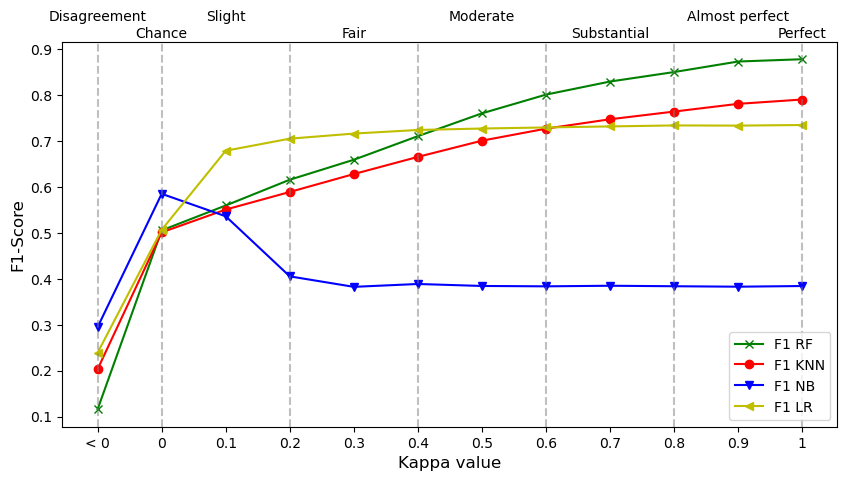

In [87]:
# Plot a simple line chart
plt.plot(agreements, rf_f1, 'g', label='F1 RF', marker='x')
plt.plot(agreements, knn_f1, 'r', label='F1 KNN', marker='o')
plt.plot(agreements, nb_f1, 'b', label='F1 NB', marker='v')
plt.plot(agreements, lr_f1, 'y', label='F1 LR', marker='<')

plt.axvline(x=0, linestyle='dashed', color='gray', alpha=0.5)
plt.axvline(x=1, linestyle='dashed', color='gray', alpha=0.5)
plt.axvline(x=3, linestyle='dashed', color='gray', alpha=0.5)
plt.axvline(x=5, linestyle='dashed', color='gray', alpha=0.5)
plt.axvline(x=7, linestyle='dashed', color='gray', alpha=0.5)
plt.axvline(x=9, linestyle='dashed', color='gray', alpha=0.5)
plt.axvline(x=11, linestyle='dashed', color='gray', alpha=0.5)

y_pos = plt.ylim()[1]

plt.text(0, y_pos * 1.05, 'Disagreement', color='black', ha='center')
plt.text(1, y_pos * 1.01, 'Chance', color='black', ha='center')
plt.text(2, y_pos * 1.05, 'Slight', color='black', ha='center')
plt.text(4, y_pos * 1.01, 'Fair', color='black', ha='center')
plt.text(6, y_pos * 1.05, 'Moderate', color='black', ha='center')
plt.text(8, y_pos * 1.01, 'Substantial', color='black', ha='center')
plt.text(10, y_pos * 1.05, 'Almost perfect', color='black', ha='center')
plt.text(11, y_pos * 1.01, 'Perfect', color='black', ha='center')

plt.legend()
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams.update({'font.size': 10})

plt.xlabel('Kappa value', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)

plt.show()